## Final Project Submission

- Student name: Jack Locke
- Student pace: Self-paced
- Instructor name: Mark Barbour

# Movie Studio Data Analysis

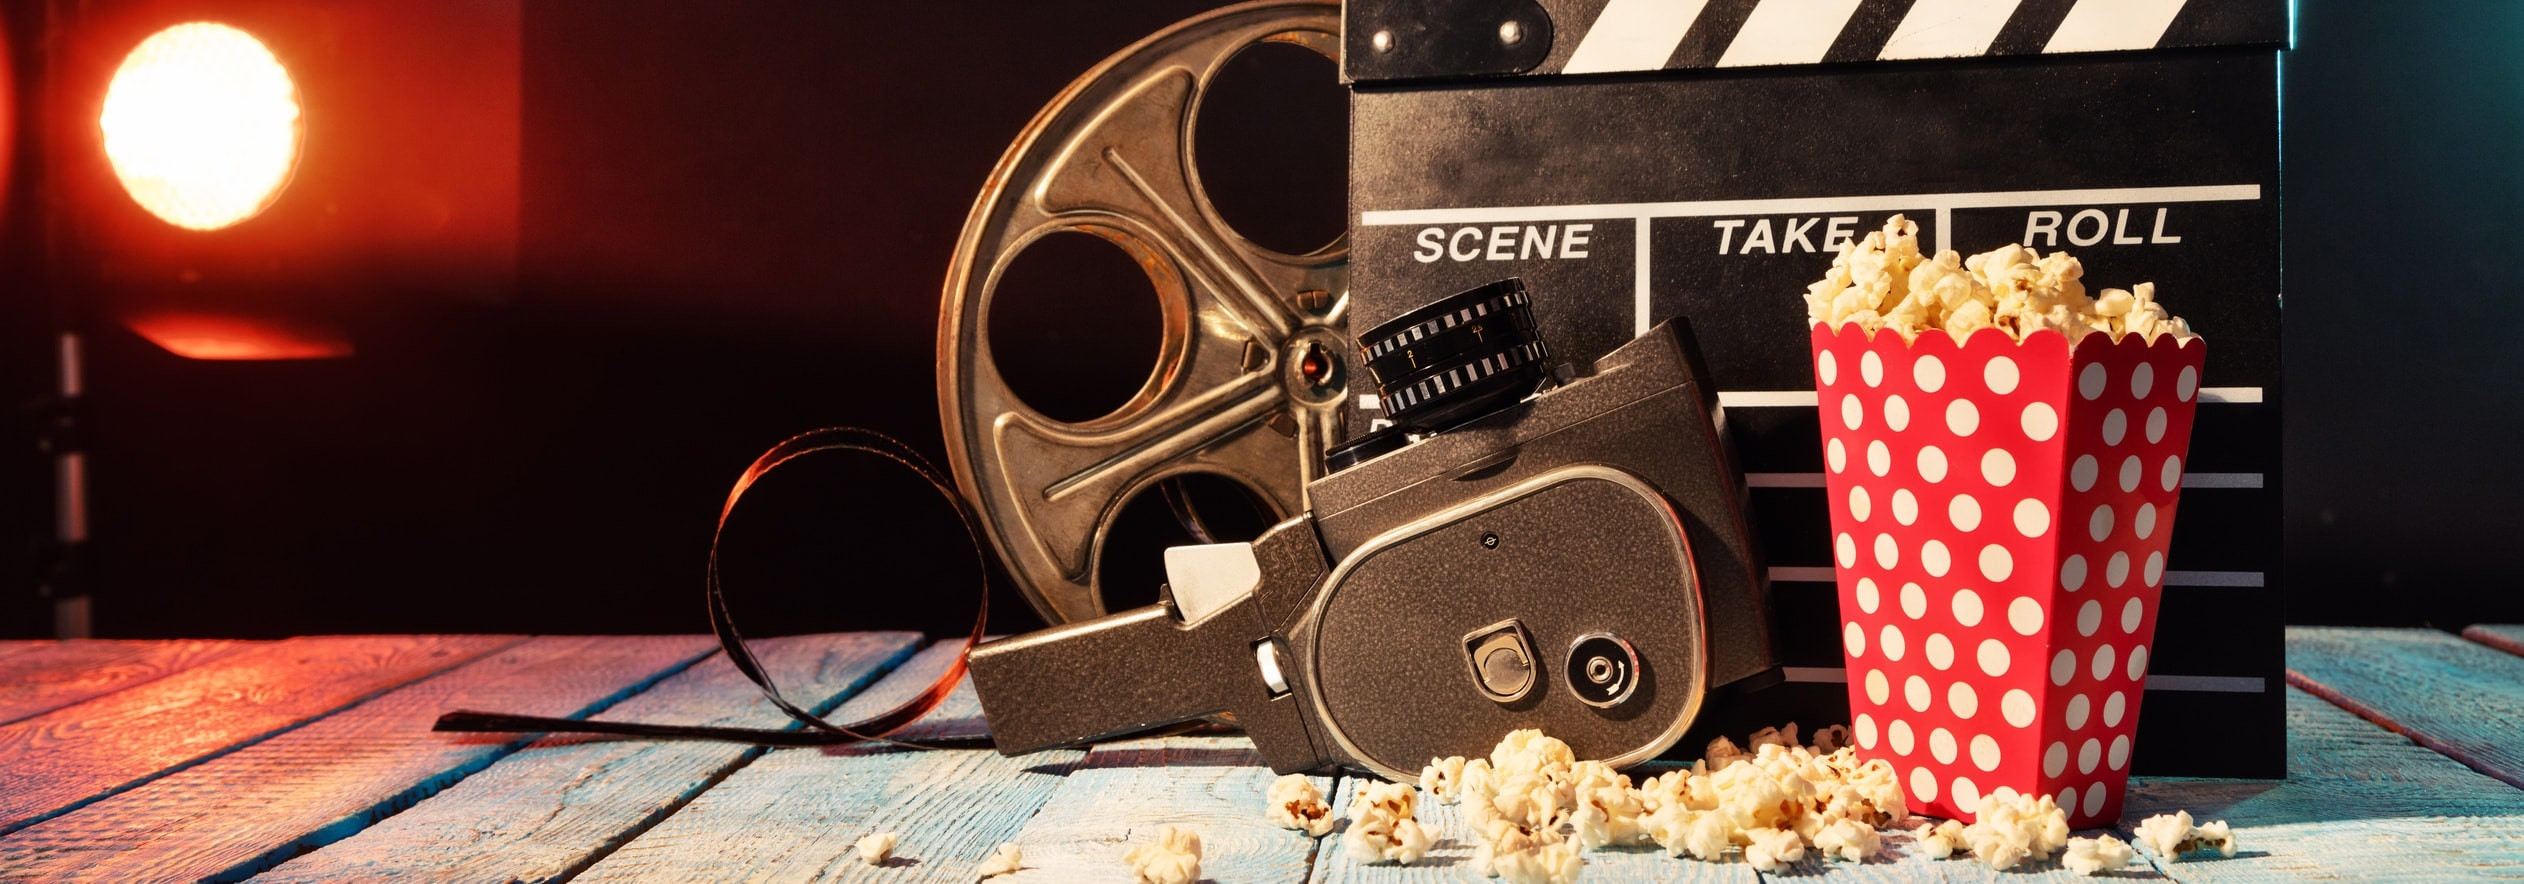

## Overview

- 1. Business Understanding
- 2. Data Understanding
- 3. Data Preparation
    - a. Merging Datasets
    - b. Drop Unnecassary Columns
    - c. Dropping Unnecessary Columns
    - d. Primary Column Information
    - e. Cleaning Primary Columns
    - f. Creating Additional Columns for Analysis
- 4. Exploratory Data Analysis
    - a. Genre vs. ROI
    - b. Released Month vs. ROI
    - c. Director vs. ROI
- 5. Conclusions
    - a. Limitations
    - b. Recommendations
- 6. Next Steps

## Business Understanding

The business stakeholder is a company creating a new movie studio because they want to break into the film industry. My project analyzes films based on box office performance data. The aim is to find patterns and trends within the data in order to provide recommendations for what filmmakers should focus on when creating films for their new movie studio. I will focus on recommending what genres, release dates, and directors will best suit the stakeholder's business when compared to their respective ROIs (return on investment). The recommendations will help the business create films that will lead to profit for the company. My analysis will use the CRISP-DM (Cross-industry standard process for data mining) methodology. 

## Data Understanding

For this project, I am working with datasets from two different resources. One dataset is from IMDB’s relational database. I will gather data about movie genres and their directors from this database. The genre and director information will come from two different tables within the relational database. The final dataset contains information on roughly 160,000 movies. 

The other dataset comes from a CSV file called Movie Budgets. This dataset contains information on movie release dates and finances, such as production budget and gross revenue. The dataset contains information on roughly 5,800 movies. 

The link attached will guide you to a github account containing the IMDB database and Movie Budgets CSV file with IMDB’s respective ERD (Entity Relationship Diagram), if you wish to clone the repository and view the data: https://github.com/learn-co-curriculum/dsc-phase-2-project-v3/tree/main/zippedData

In [1]:
#Import necessary libraries needed for data engineering/manipulation/graphing. Import library to remove warnings
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import re
import matplotlib.patches as mpatches
import seaborn as sns
import statistics
pd.options.mode.chained_assignment = None

In [2]:
#Establish connection to sql database and extract movie information needed for analysis. Put into dataframe
conn = sqlite3.Connection('data/im.db')
imdb_df = pd.read_sql("""

SELECT primary_title, runtime_minutes, genres, start_year, movie_id
FROM movie_basics

;""",conn)
imdb_df.head()

,primary_title,runtime_minutes,genres,start_year,movie_id
0,Sunghursh,175.0,"Action,Crime,Drama",2013,tt0063540
1,One Day Before the Rainy Season,114.0,"Biography,Drama",2019,tt0066787
2,The Other Side of the Wind,122.0,Drama,2018,tt0069049
3,Sabse Bada Sukh,NaN,"Comedy,Drama",2018,tt0069204
4,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy",2017,tt0100275


In [3]:
#Query sql database to get information on movie directors. Put into dataframe. Duplicate rows with same information. 
#Use distinct to solve issue. 
director_df = pd.read_sql("""

SELECT DISTINCT movie_id, person_id, primary_name
FROM directors
JOIN persons
USING(person_id)


;""",conn)
director_df.head()

,movie_id,person_id,primary_name
0,tt0285252,nm0899854,Tony Vitale
1,tt0462036,nm1940585,Bill Haley
2,tt0835418,nm0151540,Jay Chandrasekhar
3,tt0878654,nm0089502,Albert Pyun
4,tt0878654,nm2291498,Joe Baile


In [4]:
#Connect to movie budget csv file and put it into a dataframe
tn_df = pd.read_csv('data/tn.movie_budgets.csv.gz')
tn_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


## Data Preparation

 - Merging Datasets into one combined dataframe
 - After merging the dataset we will deal with repeated rows
 - Drop the unnecessary columns from our dataframe
 - Get information on our primary columns
 - Clean the dataframe
 - Create columns needed for our EDA

#### Merging datasets

I currently have three datasets: two from the IMBD database and one from the Movie Budget CSV file. Our recommendations require all datasets to be combined into one dataframe, as I will need to compare what the stakeholders can control with the financial data.

In [5]:
#Combine the two sql datasets so directors are linked to movie information they are involved with. Use inner join 
#so it is just rows of movie_ids present in both datasets. 
director_movie_df = director_df.merge(imdb_df, on='movie_id', how = 'inner')
director_movie_df.head()

,movie_id,person_id,primary_name,primary_title,runtime_minutes,genres,start_year
0,tt0285252,nm0899854,Tony Vitale,Life's a Beach,100.0,Comedy,2012
1,tt0462036,nm1940585,Bill Haley,Steve Phoenix: The Untold Story,110.0,Drama,2012
2,tt0835418,nm0151540,Jay Chandrasekhar,The Babymakers,95.0,Comedy,2012
3,tt0878654,nm0089502,Albert Pyun,Bulletface,82.0,Thriller,2010
4,tt0878654,nm2291498,Joe Baile,Bulletface,82.0,Thriller,2010


In [6]:
#I am joining the sql dataset with the csv dataset. In order to make sure I am not unnecessarily losing matches 
#because of capitalization issues, I am putting all of the movie titles in lowercase. 
tn_df['movie'] = tn_df['movie'].apply(lambda x: x.lower())
director_movie_df['primary_title'] = director_movie_df['primary_title'].apply(lambda x: x.lower())

In [7]:
#Merge the datasets together using the movie titles. Use inner join to make sure final dataframe is just matching
#results for both. 
combined_df = tn_df.merge(director_movie_df, left_on='movie', right_on='primary_title', how = 'inner')

In [8]:
#Length of dataframe is longer than length of tn_df that we merged on meaning there are multiple primary_titles
#that match the movie titles. Will have movies that have multiple directors. Additionally, some movies have the 
#same title but are not the same movie. Will handle this issue in the next step. For example, 'avatar' budgets 
#below are referring to the famous avatar movie by james cameron and not the horror film it is associated with 
#right now. 
combined_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,person_id,primary_name,primary_title,runtime_minutes,genres,start_year
0,1,"Dec 18, 2009",avatar,"$425,000,000","$760,507,625","$2,776,345,279",tt1775309,nm3786927,Atsushi Wada,avatar,93.0,Horror,2011
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650,nm0551128,Rob Marshall,pirates of the caribbean: on stranger tides,136.0,"Action,Adventure,Fantasy",2011
2,3,"Jun 7, 2019",dark phoenix,"$350,000,000","$42,762,350","$149,762,350",tt6565702,nm1334526,Simon Kinberg,dark phoenix,113.0,"Action,Adventure,Sci-Fi",2019
3,4,"May 1, 2015",avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427,nm0923736,Joss Whedon,avengers: age of ultron,141.0,"Action,Adventure,Sci-Fi",2015
4,7,"Apr 27, 2018",avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",tt4154756,nm0751577,Anthony Russo,avengers: infinity war,149.0,"Action,Adventure,Sci-Fi",2018


#### Filtering repeated rows

When I merged the datasets on the movie titles, I discovered some movies have duplicate titles. I do not want financial data to be linked to the incorrect movie titles, skewing our results. To fix this, I will use the 'release_date' column and create a new column, 'matching_year'. I can then compare ‘matching_year’ with the 'start_year' column. This will help match the correct movies with the proper financial data. This will not be perfect as there will be movies with duplicate titles also released in the same year. But, this will significantly reduce our issue. The number of movies released the same year with duplicate titles is small. I am also using median values for my recommendations, so this small number of rows I cannot filter out will not significantly impact our results. 

In [9]:
#Creating column 'matching year' using 'release_date' last four characters and setting into to a number for 
#comparison usage. Compare the two year columns present from the prior datasets to match relevant information. 
combined_df['matching_year'] = combined_df['release_date'].apply(lambda x: x[-4:]).astype(float)
combined_df = combined_df[(combined_df['start_year'] == combined_df['matching_year'])]

#### Dropping Unnecessary Columns

In [10]:
#Will be removing other columns as we progress; create drop function for reusability
def drop(cols,df):
    '''Is going to take the column name and apply the drop function'''
    for x in cols:
        df.drop(columns=x, inplace=True)

In [11]:
#Dropping columns that do not have relevance for the remaining part of our analysis.
drop(['id','primary_title', 'start_year', 'matching_year','domestic_gross', 'movie_id', 'person_id'], combined_df)


#### Primary Columns Information

Want to view what the stakeholders can control:
- Release dates
- Genres
- Directors

With measurements of success (used to create Gross Profit and Gross ROI):
- Production budget
- Gross Revenue

In [12]:
#Information on our combined dataframe to see datatypes and null values.
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1747 entries, 1 to 4242
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       1747 non-null   object 
 1   movie              1747 non-null   object 
 2   production_budget  1747 non-null   object 
 3   worldwide_gross    1747 non-null   object 
 4   primary_name       1747 non-null   object 
 5   runtime_minutes    1721 non-null   float64
 6   genres             1742 non-null   object 
dtypes: float64(1), object(6)
memory usage: 109.2+ KB


In [13]:
#Strings of release dates
combined_df['release_date'].value_counts()

release_date
Dec 31, 2014    17
Jan 25, 2013    15
Dec 31, 2010    11
Sep 23, 2011    10
Dec 31, 2015    10
                ..
Mar 29, 2018     1
Mar 22, 2019     1
Jan 18, 2019     1
Nov 16, 2011     1
Jan 27, 2017     1
Name: count, Length: 622, dtype: int64

In [14]:
#Strings of movie titles. See movies appear more than once for each director involved and see how some movies had 
#the same title and same release year. Luckily, when manually viewing these instances, the number of movies that
#have the same title and same year that do not correctly link to the right financial data is very small. 
combined_df['movie'].value_counts()

movie
movie 43                13
freakonomics             6
the promise              5
locker 13                5
redemption               4
                        ..
only the brave           1
rush                     1
the 5th wave             1
riddick                  1
stories of our lives     1
Name: count, Length: 1525, dtype: int64

In [15]:
#See how genre column represents many genres for the same movie. Will handle this later in the analysis. 
#Additionally, there are some missing genre values.
combined_df['genres'].value_counts()

genres
Adventure,Animation,Comedy    107
Comedy                         81
Drama                          69
Action,Adventure,Sci-Fi        58
Comedy,Drama,Romance           57
                             ... 
Adventure,Comedy,Romance        1
Comedy,Sci-Fi                   1
Comedy,Drama,Sport              1
Adventure,Comedy,Sci-Fi         1
Comedy,Horror,Thriller          1
Name: count, Length: 235, dtype: int64

In [16]:
#See the movie counts for directors
combined_df['primary_name'].value_counts()

primary_name
Tim Story            8
Steven Spielberg     7
Clint Eastwood       7
Jon M. Chu           6
Ridley Scott         6
                    ..
Billy Ray            1
James Mather         1
Steve Saint Leger    1
Mark Mylod           1
Jim Chuchu           1
Name: count, Length: 1187, dtype: int64

In [17]:
#Financial data is a string that will need to be converted to an integer
combined_df['worldwide_gross'].value_counts()

worldwide_gross
$0              136
$31,164,747      13
$172,867          6
$3,496            5
$10,551,417       5
               ... 
$41,294,674       1
$101,162,106      1
$95,989,590       1
$126,069,509      1
$489,792          1
Name: count, Length: 1407, dtype: int64

In [18]:
#Financial data is a string that will need to be converted to an integer
combined_df['production_budget'].value_counts()

production_budget
$10,000,000    79
$20,000,000    74
$30,000,000    56
$5,000,000     55
$40,000,000    52
               ..
$19,500,000     1
$19,200,000     1
$19,100,000     1
$17,700,000     1
$15,000         1
Name: count, Length: 261, dtype: int64

#### Cleaning Primary Columns 

After viewing our primary columns, I will need to change 'production_budget' and 'worldwide_gross'(gross revenue) into integer datatypes so I can create additional columns for measurements. Additionally, there are missing values in 'runtime_minutes' and 'genres' that need to be filled in. 

In [19]:
#Creating function for reusability on financial data
def money_values(lst):
    
    ''' The function will take in a list of column names (lst) for financial data that are strings and convert
        those strings to integers so they can be used to create additional financial columns'''
    
    for df in lst:
        combined_df[df] = combined_df[df].apply(lambda x: re.sub(r'[^\w\s]', '', x))
        combined_df[df] = combined_df[df].apply(int)
        
# Citation: 1. Source for using re.sub

In [20]:
#Passing in financial columns into the money_values function
monetary_columns_lst = ['production_budget', 'worldwide_gross']
money_values(monetary_columns_lst)

In [21]:
#The runtime column has missing values. Will fill the missing values with the mean so we can filter down data
#so movies in the dataframe are more than 30 minutes long. 
combined_df['runtime_minutes'] = combined_df['runtime_minutes'].fillna(combined_df['runtime_minutes'].mean())
combined_df = combined_df[combined_df['runtime_minutes']>30]
drop(['runtime_minutes'],combined_df)

In [22]:
#Resetting the index so it starts at 0 because I will be manually filling in the missing genre information by 
#indexing. 
combined_df.reset_index(drop=True, inplace=True)

In [23]:
#Create reusable function to handle the missing genre data. 
def missing_genre(index, typ):
    
    '''Will take the dataframe index (index) and set the genre to its specific type (typ)'''
    
    combined_df.loc[index,'genres'] = typ

In [24]:
#Call the missing_genre function to fill in our missing genre values with their true genres. 
missing_genre(32,'Action,Adventure')
missing_genre(515,'Comedy,Action')
missing_genre(516,'Comedy,Action')
missing_genre(996,'Action,Thriller')
missing_genre(1115,'Drama')

#### Creating Additional Columns for Analysis

My EDA will be looking into the best release dates based on their months. I will need to use the 'release_date' column to create a new column for the month it was released, 'month'. 

Additionally, I will be creating a ROI column as a success measurement. I will need to take 'worldwide_gross' and subtract 'production_budget' to create a new column, 'gross_profit'. From there, I can take 'gross_profit' and divide it by 'production_budget', multiply it by 100, to get the 'gross_roi' percentage. The 'gross_roi' column will be what I use as my measurement of success. 

In [25]:
#Using the release date to create a new column representing just the month it was release for our EDA. These are the
#first three characters of the column.
combined_df['month'] = combined_df['release_date'].apply(lambda x: x[:3])

In [26]:
#I have essentially created a new release date column so I can drop the old one.  
drop(['release_date'],combined_df)

In [27]:
#My EDA needs gross ROI and in order to do this I need a column for gross profit. I could have done both in one
#line of code but I feel that having a gross profit column in the analysis might be beneficial for the future in 
#case I need to look at gross profit more specifically in the next steps. 
combined_df['gross_profit'] = combined_df.apply(lambda x: x['worldwide_gross'] - x['production_budget'], axis=1)

In [28]:
#Used the gross profit column with production budget to get an ROI percentage for each movie. 
combined_df['gross_roi'] = combined_df.apply(lambda x: round((x['gross_profit'] / x['production_budget'])*100,2), 
                                                                                                         axis=1)

## Exploratory Data Analysis

As mentioned in previous sections, I will explore what the stakeholders can control with my created measurement of success. I will examine which genres, months, and directors are the most highly represented. I will need additional data engineering to show my results graphically. I will view the relationships with bar graphs as this will best show us the most highly represented values. I will be looking at the median gross ROI values. Extreme outliers are present in the data, so using the mean will lead to highly skewed results. I will use the median to accurately measure the central tendency to reflect the data. 

Currently, our combined dataframe has movies repeated for each director. So, if a movie title has two directors, all the other information will be repeated twice. The issue is ROIs, genres, and months will be represented twice for the same movie. If kept, this will skew our results, giving more weight to those columns. To fix this, I will create new dataframes of the relevant information for each analysis and drop any duplicated rows, thus removing additional rows when there is more than one director. But, this information will be kept for the director's analysis. 


#### Genre vs. ROI

Movies have more than one genre associated with them. I want to see how the genres perform individually so the stakeholders can understand the combinations of genres they can create for success. We can’t know which genre made individuals decide to go to a movie, so they all have to be represented equally. For example, if it is an action/adventure movie with a 10% ROI, then both action and adventure will receive a 10% value. I will create a dictionary with the keys being each genre, and their values will be a list of all their associated ROIs. I will then sort it by median ROI, transform the dictionary into a dataframe, and graph the top five most highly represented genres.

In [29]:
#Creating a dataframe for analysis that will help remove movies that have multiple directors and will be simple to 
#visualize via table and graph. 
genre_df = combined_df[['movie','gross_roi', 'genres']]

In [30]:
#Dropping the duplicate movie rows. 
genre_df = genre_df.drop_duplicates()

# 2. Source for drop duplicate rows

In [31]:
#We do not have any movies where the genre column exceeds three individual genres. But I need to split each one of
#this genres up individually. In order to do this I am creating three new columns: genre1,genre2,genre3. What each
#line does is goes through the dataframe looking at the genre column, it will split the column values based on 
#commas and .iloc will specify which location to look at. It will assign the genre name to the new genre column and 
#if the genre column does not exist, then it will populate that value with none. For example, if the genre is 
#action/adventure, the new columns will be: genre1 Action, genre2 Adventure, genre3 None. The reasoning is so later
#I can easily loop through the new dataframe and create a dictionary that takes the genres as keys and creates a 
#list of each of their associated ROIs. 
genre_df = genre_df.assign(genre1 = genre_df.genres.str.split(",", expand = True).iloc[:,:1],
                           genre2 = genre_df.genres.str.split(",", expand = True).iloc[:,1:2],
                           genre3 = genre_df.genres.str.split(",", expand = True).iloc[:,2:3])

# Citation: 3. Source used to assign new columns, off of split and iloc

In [32]:
#I created new genre columns so I can drop the old genre column. 
drop(['genres'],genre_df)

In [33]:
#I need to create a list of all the unique genre types in order to create the dictionary.
lst_1 = list(genre_df['genre1'].unique())
lst_2 = list(genre_df['genre2'].unique())
lst_3 = list(genre_df['genre3'].unique())
lst_1.extend(lst_2)
lst_1.extend(lst_3)
genre_unique_lst = list(set(lst_1))

In [34]:
#Creates a dictionary with the genres types as the keys and the values as an empty list. 
genre_dict = dict([(x,[]) for x in genre_unique_lst])

In [35]:
#Now I will loop through the genre dataframe by index. It will grab the genre type from each genre column and add
#its ROI to the list associated with that genre key. For example, lets say row one has genre1 - action, genre2 - 
#adventure genre3 - None, gross_roi - 10.0. Genre dictionary is looking at the the first index for genre1 
#which is action, it is putting that in genre dictionary so it is looking at the action key, and then it will append
#the gross_roi value of that same index, 0, that is 10. Adding 10 to the list for the action key. Then it will move
#on to genre2 and do the same thing, assigning 10 to the adventure key. It will do the same thing with genre3 with
#the None key. So at the end I will just need to remove None from the dictionary. 
for i in genre_df.index:
    genre_dict[genre_df['genre1'][i]].append(genre_df['gross_roi'][i])
    genre_dict[genre_df['genre2'][i]].append(genre_df['gross_roi'][i])
    genre_dict[genre_df['genre3'][i]].append(genre_df['gross_roi'][i])
    
# Citation 4. Source for looping through dataframe by index and assigning dicitonary keys/values

In [36]:
#Now I am using dictionary comprehension to loop through the genre dictionary and create a new genre dictionary
#that just has the median ROI value for each key. Thus getting the median ROI for each genre. I will then sort that
#dictionary in descending order. 
genre_dict = dict((k,round(statistics.median(v),2))for k,v in genre_dict.items())
genre_dict = dict(sorted(genre_dict.items(), key=lambda item: item[1], reverse=True))

# Citation 5. Source for dictionary comprehension
# Citation 6. Source for using statistics median 
# Citation 7. Source for sorting dictionary

In [37]:
#Now I will convert the dictionary back into a table so it would be easier to see via table and then will be easy
#to graph the top 5 most highly represented genres. 
genre_roi_df = pd.DataFrame.from_dict(genre_dict.items())
genre_roi_df.columns = ['genre','gross_roi']
genre_roi_df = genre_roi_df.head()

In [38]:
#I just want to represent the ROI percentages as whole numbers. Will be using this for all three EDA graphs so I 
#will create a reusable function.
def round_percent(df): 
    
    '''Will take in a dataframe (df) and change the ROI percent to a whole number'''
    
    df['gross_roi'] = df['gross_roi'].apply(lambda x: round(x))

In [39]:
round_percent(genre_roi_df)

In [40]:
#The bar graph will be created by using genre for the x axis and gross roi for the y axis. 
def bar_graph(x,y,df,title,xlabel,ylabel):

    plt.figure(figsize=(14, 6))

    ax1 = sns.barplot(x=x,  y=y, data=df, color='darkblue')

    ax1.bar_label(ax1.containers[0],size=16)
    # show the graph

    plt.title('ROI by ' + title,fontsize=20)
    plt.xlabel(xlabel,fontsize=18)
    plt.ylabel(ylabel,fontsize=18)
    plt.tick_params(axis='y',labelsize=16)
    plt.tick_params(axis='x',labelsize=16)
    plt.show()

# Citation 8. Source used for labeling top of the bar graph columns

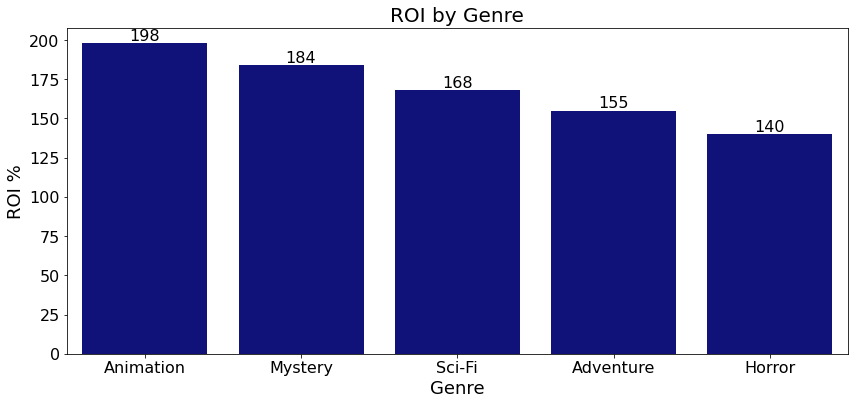

In [41]:
bar_graph('genre','gross_roi', genre_roi_df, 'Genre', 'Genre', 'ROI %')

#### Released Month vs. ROI

The month is more straightforward than the genre. After removing duplicative director rows, I will use a groupby statement to match months with their median ROIs, sort the values, and graph the five most highly represented months. Determining the appropriate release date will lead to a higher chance of profit for the stakeholder. The stakeholder wants to know when people will see/pay for movies, ultimately leading to a higher likelihood of success.   

In [42]:
#Creating a dataframe for analysis that will help remove movies that have multiple directors and will be simple to 
#visualize via table and graph.
month_df = combined_df[['movie', 'gross_roi', 'month']]

In [43]:
#Dropping the duplicate movie rows. 
month_df = combined_df.drop_duplicates()

In [44]:
#Grouping each month with its median ROI value and resetting the index so it is represented as columns for graphing.
month_roi_df = month_df.groupby('month')[['gross_roi']].median().reset_index()

In [45]:
#Sorting the months by descending ROI values to get the top 5 most highly represented months. 
month_roi_df = month_roi_df[['month','gross_roi']].sort_values(by='gross_roi',ascending=False).reset_index(
                                                                                                drop=True).head()

In [46]:
#I just want to represent the ROI percentages as whole numbers. 
round_percent(month_roi_df)

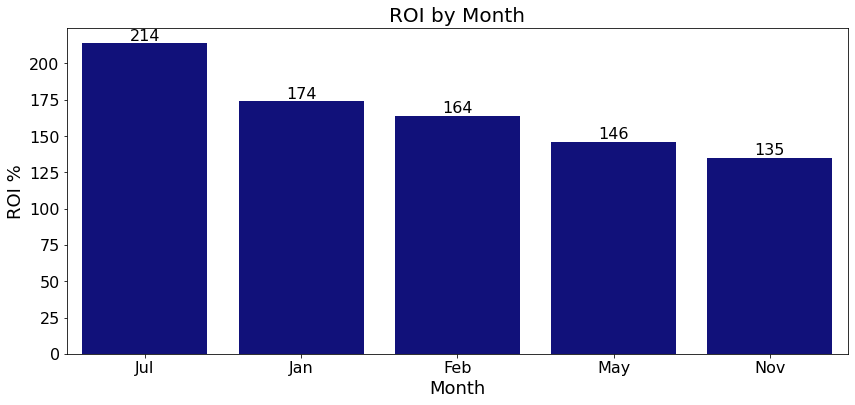

In [47]:
bar_graph('month','gross_roi', month_roi_df, 'Month', 'Month', 'ROI %')

#### Directors vs. ROI

It is important to note, directors can produce a movie with great ratings, but if the director does not know how to appropriately handle the financial budget of said movie then they will not produce profitable returns. I want to see which directors not only produce a good movie but also handle the financial aspects of said movie. The stakeholders can use these directors to help create the most successful/profitable movies. 

Similarly to months, I will use a groupby statement to group my directors with their respective median ROIs, sort the values, and graph the seven most highly represented directors. I will look at directors involved in five or more movies, ensuring the analysis only represents reputable directors. There needs to be more data to define a trajectory for a director to see if they are progressing for each movie, but I don't have data on every movie a director has been a part of. So, for the sake of the analysis and to err on the side of caution, I will still use median values for their ROIs. The names of the directors in my top seven give me confidence in this approach, as they are all recognizable names. 

In [48]:
#Creating a dataframe for analysis that will be simple to visualize via table and graph.
director_roi_df = combined_df[['movie','primary_name','gross_roi']]

In [49]:
#Creating a dataframe that has median ROI for each director and shows how many movies they have directed. 
director_roi_df = director_roi_df.groupby('primary_name')[['gross_roi', 'movie']].agg({'gross_roi':'median',
                                                                                      'movie':'count'}).sort_values(
                                                                                       by='gross_roi', 
                                                                                       ascending=False)

In [50]:
#Filtering out directors that have produced less than five movies and taking the top seven most highly represented 
#directors
director_roi_df = director_roi_df[director_roi_df['movie']>=5].head(7).reset_index()

In [51]:
#I just want to represent the ROI percentages as whole numbers. 
round_percent(director_roi_df)

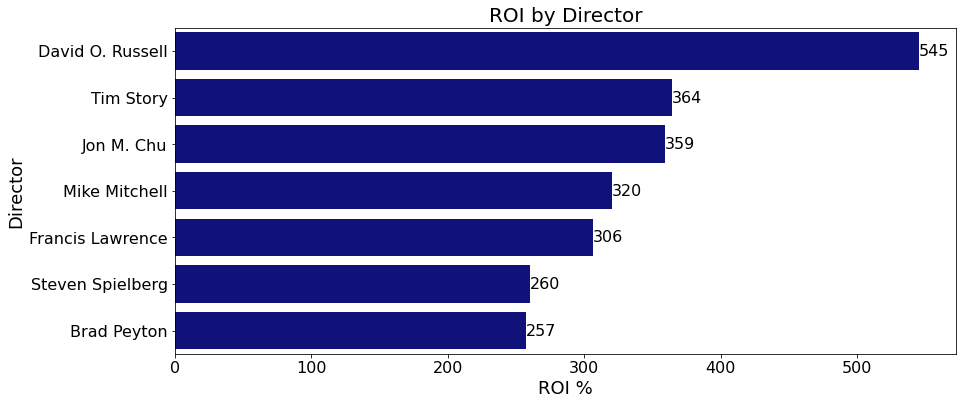

In [52]:
bar_graph('gross_roi','primary_name', director_roi_df, 'Director', 'ROI %', 'Director')

## Conclusions

My Exploratory Data Analysis presents three business findings. The findings will help the business stakeholders figure out specific attributes of movies to help release successful films for their new studio, which, in turn, will lead to a profitable increase for their company. Given these findings and data enrichment in the future, I can build on my recommendations and know where to proceed next. 

#### Limitations


The data possesses many limitations at this stage. I do not have information on every movie release date, genre, and director in the film industry. Additionally, this is gross financial data, so I do not have data on every financial cost that could impact my ROIs. Due to this missing data, I cannot confidently say which movie attributes best suit the company. I can only determine which movie attributes are the most highly represented compared to my measurement of success. Representation will help show us trends and patterns in the data. From there, I can recommend what actions need to be taken in the future to confirm my suspicions on which movie attributes have the potential to lead to the most profit.


#### Recommendations

I recommend investigating these three recommendations further as we enrich the data and become more confident in our results. 
c: I assessed each genre with median ROI to show the five most highly represented genres. 
    - Animation
    - Mystery
    - Sci-Fi
    - Adventure
    - Horror
- 2. **Released Month vs. ROI**: I assessed each release month with median ROI to show the five most highly represented months.
    - July
    - January
    - February
    - May
    - November
- 3. **Director vs. ROI**: I assessed each director with median ROI to show the seven most highly represented directors. 
    - David O. Russell
    - Tim Story
    - Jon M. Chu
    - Mike Mitchell
    - Francis Lawrence
    - Steven Spielberg
    - Brad Peyton


## Next Steps

Data enrichment is crucial to help us confirm our business recommendations. As mentioned, without more information on movie genres, release dates, directors, and additional financial costs, I can’t say with absolute certainty what movie attributes are best. ROIs could change as more financial costs are presented, leading to different results for our most highly represented genres, release dates, and directors. However, as the data increases, I can start to confirm or deny our suspicions. 

In the next steps, I would suggest finding more information on the following:
- More movies → additional information on our highly represented genres, release dates, and directors
- Additional financial costs not accounted for or that occured after the box office release → transition from gross ROI to net ROI
    - Additional post-production costs
    - Additional revenue generated
    - Streaming costs



#### Citations

1. https://stackoverflow.com/questions/23996118/replace-special-characters-in-a-string-in-python
2. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
3. https://datascience.stackexchange.com/questions/74277/extract-seperated-value-from-columns
4. https://www.geeksforgeeks.org/different-ways-to-iterate-over-rows-in-pandas-dataframe/
5. https://stackoverflow.com/questions/2315520/in-python-how-do-i-loop-through-the-dictionary-and-change-the-value-if-it-equal
6. https://www.geeksforgeeks.org/find-median-of-list-in-python/
7. https://stackoverflow.com/questions/20577840/python-dictionary-sorting-in-descending-order-based-on-values
8. https://stackoverflow.com/questions/43214978/how-to-display-custom-values-on-a-bar-plot
